In [1]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [2]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
mpl.rcParams['pdf.fonttype'] = 42

In [93]:
dataOp425_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))
dataOp622_AL33 = wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))
dataOp820_AL34 = wfOpto(Path(r'Y:\Subjects\AL_0034\2024-08-20\1'))

In [116]:
dataOp425_AB32 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [ ]:
dataVis824_AL23 = wfOpto(Path(r'Y:\Subjects\AL_0023\2024-08-24\1'))

In [4]:
dataVis830_AL23 = wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-30\1')) #fine but only one location

In [5]:
dataVis830_AL23.svdTemp.shape

(172189, 50)

In [6]:
dataVis830_AL23.svdSpat.shape

(313600, 50)

In [18]:
dataVis824_AL23 = wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-24\1')) #barely shows up

In [69]:
dataVis825_AL23 = wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-25\2')) #barely shows up

In [14]:
dataVis904_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-04\1'))

In [7]:
dataVis910_AL35=wfOpto(Path(r'Y:\Subjects\AL_0035\2024-09-10\1')) # good 

In [98]:
dataVis822_ZYE=wfOpto(Path(r'Y:\Subjects\ZYE_0077\2024-07-22\1')) #too small, not on the same scale

In [8]:
dataVis819_ZYE=wfOpto(Path(r'Y:\Subjects\ZYE_0087\2024-08-19\1')) #good

In [9]:
dataVis823_ZYE = wfOpto(Path(r'Y:\Subjects\ZYE_0088\2024-08-23\1')) # good

In [30]:
linTest = np.load(Path(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\linTestDff.npy'),allow_pickle=True)

In [31]:
linTest = linTest.item()

In [32]:
linWindows = np.load(Path(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\wf + opto\figure-making\linTestWindow.npy'),allow_pickle=True)

# stat func

In [ ]:
def ttestpowquant(data,galvoX,galvoY,baseline_ind,test_ind,start=-.3,end=0.1,width=30,x=120,y=380,trialtrs=29,t=1350):
    #my indices 
    n_samples = round((end-start) * 35)
    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
    avg = np.mean(avg,axis=(0,1))

    galvoX=np.argwhere(data.galvoX[:t]==galvoX).ravel()
    galvoY=np.argwhere(data.galvoY[:t]==galvoY).ravel()
    loc=np.intersect1d(galvoX,galvoY)

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    powers=np.unique(data.laserPowers)

    #checkers
    baselines=[]
    activities=[]

    for i,pow in enumerate(powers):

        #get our trial activity for both baseline period and stim period 
        pwTrs = np.argwhere(data.laserPowers[:t] == pow).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        trial_activity=np.array(trial_activity[:trialtrs])

        #get my threshold
        baselines.append(trial_activity[:,:baseline_ind])
        activities.append(trial_activity[:,test_ind:])
    baselines = np.mean(baselines,axis=2)
    activities=np.mean(activities,axis=2)
    return scipy.stats.ttest_rel(baselines,activities,axis=1)

In [ ]:
def ttestpowquant_foropto(data,galvoX,galvoY,baseline_ind,test_ind,start=-.3,end=0.1,width=30,x=120,y=380,trialtrs=40):
    #my indices 
    n_samples = round((end-start) * 35)
    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
    avg = np.mean(avg,axis=(0,1))

    galvoX=np.argwhere(data.galvoX==galvoX).ravel()
    galvoY=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoX,galvoY)

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    powers=np.unique(data.laserPowers)

    #checkers
    baselines=[]
    activities=[]

    for i,pow in enumerate(powers):

        #get our trial activity for both baseline period and stim period 
        pwTrs = np.argwhere(data.laserPowers == pow).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        trial_activity=np.array(trial_activity[:trialtrs])

        #get my threshold
        baselines.append(trial_activity[:,:baseline_ind])
        activities.append(trial_activity[:,test_ind:])
    baselines = np.mean(baselines,axis=2)
    activities=np.mean(activities,axis=2)
    return scipy.stats.ttest_rel(baselines,activities,axis=1)

In [ ]:
def baselinesandactivities(data,galvoX,galvoY,baseline_ind,test_ind,start=-.3,end=0.1,width=30,x=120,y=380,tr1=0,tr2=600,trialtrs=29):
    #my indices 
    n_samples = round((end-start) * 35)
    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
    avg = np.mean(avg,axis=(0,1))

    galvoX=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
    galvoY=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
    loc=np.intersect1d(galvoX,galvoY)

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    powers=np.unique(data.laserPowers)

    #checkers
    baselines=[]
    activities=[]

    for i,pow in enumerate(powers):

        #get our trial activity for both baseline period and stim period 
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == pow).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        trial_activity=np.array(trial_activity[:trialtrs])

        #get my threshold
        baselines.append(trial_activity[:,:baseline_ind])
        activities.append(trial_activity[:,test_ind:])
    baselines = np.mean(baselines,axis=2)
    activities=np.mean(activities,axis=2)
    return baselines,activities

# a

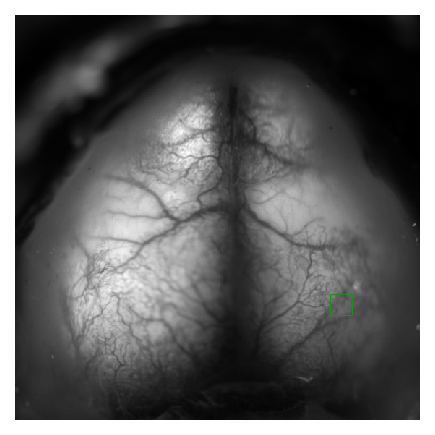

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(dataVis910_AL35.meanImage,cmap='gray')
plt.axis('off')
# Center coordinates
center_x, center_y = 450, 400
# plt.scatter(x=center_x, y=center_y, s=5, c='red')

# Rectangle dimensions
width, height = 30, 30
# Calculate bottom-left corner coordinates
bottom_left_x = center_x - width / 2
bottom_left_y = center_y - height / 2

# Create rectangle with center as anchor point
rect = Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=0.5, edgecolor='forestgreen', facecolor='none')
ax.add_patch(rect)
fig.savefig('paperposterfigs/3a_left.pdf',dpi=300,bbox_inches='tight')

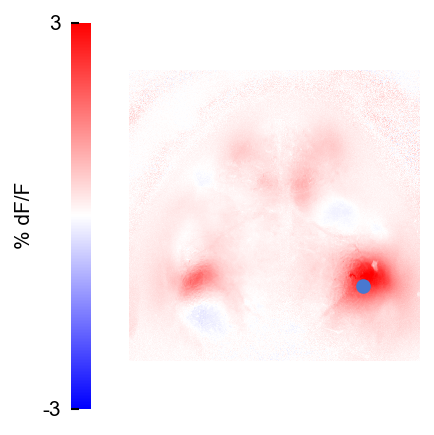

In [174]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
data=dataVis910_AL35
power=2
galvoX=0;galvoY=0;start=0;end=1
frame=5
vmax=0.030
vmin=-0.030
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
im = ax.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
# plt.scatter(x=415,y=415)
plt.axis('off')
cbar=plt.colorbar(im,ax=ax,location='left')
cbar.set_ticks([-0.03,0.03])
cbar.set_ticklabels(['-3','3'])

cbar.outline.set_visible(False)
cbar.set_label('% dF/F')
# fig.savefig('paperposterfigs/3a_right.pdf',dpi=300)
plt.scatter(x=450,y=415)

# fig = plt.figure(figsize=(10,14))
# gs=mpl.gridspec.GridSpec(5,7)
# for i in range(35):
#     ax = fig.add_subplot(gs[i])
#     plt.imshow(mov_mean_dff[:,:,i], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
#     plt.colorbar()
#     plt.axis('off')

# b

In [15]:
def visresp(ax,data,powers,galvoX=0,galvoY=0,x=400,y=400,width=15):
    n_samples = round(start*-1+end)*35
    colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
    pxPowers = []
    sems=[]
    timestamps = np.linspace(start, end, n_samples)
    galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for power in powers:
        pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        pxPowers.append(np.mean(trial_activity,axis=0))
        powerscorr = [round(i/2.777777778,2) for i in powers]

    ax = plt.subplot(gs[0,0])
    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

    for iP, power in enumerate(pxPowers):
        plt.fill_between(timestamps, \
                power-sems[iP],\
                power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

    plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
    plt.xlim([-.1,0.6])
    plt.xticks([0,0.2,0.4,0.6],[0,0.2,0.4,0.6])
    cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
    cm.set_clim(0, 3/2.7) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
    plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
    plt.ylim([-.01,.03])
    plt.xlabel('Time (s)')
    plt.ylabel('Activity in VISp (dF/F)')

In [176]:
data=dataVis910_AL35
powers=np.unique(data.laserPowers)
galvoX=0;galvoY=0;x=450;y=415;width=15;anchor=(1,1)
ylim=[-0.01,0.008];start=-0.3;end=1;xlim=[-0.01,0.5]
t=1350
n_samples = round(start*-1+end)*35
colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
pxPowers = []
sems=[]
timestamps = np.linspace(start, end, n_samples)
galvoXTr=np.argwhere(data.galvoX[:t]==galvoX).ravel()
galvoYTr=np.argwhere(data.galvoY[:t]==galvoY).ravel()
loc=np.intersect1d(galvoXTr,galvoYTr)

meanimg = data.meanImage.reshape(560,560,-1)
avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
avg = np.mean(avg,axis=(0,1))

y_range = np.arange(y - width, y + width)
x_range = np.arange(x - width, x + width)
# Create a meshgrid of the coordinates
y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
# Flatten the coordinate arrays
y_coords_flat = y_coords.flatten()
x_coords_flat = x_coords.flatten()
# Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

for power in powers:
    pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
    theseTrs=np.intersect1d(pwTrs,loc)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    trial_activity=[]
    for trial in trs:
        wf = data.tToWFManual(trial)
        mov = data.svdSpat[flat_indices] @ wf.T
        videoROI_avg = np.mean(mov,axis=0)
        dff = videoROI_avg/avg
        trial_activity.append(dff)
    sems.append(scipy.stats.sem(trial_activity,axis=0))
    pxPowers.append(np.mean(trial_activity,axis=0))

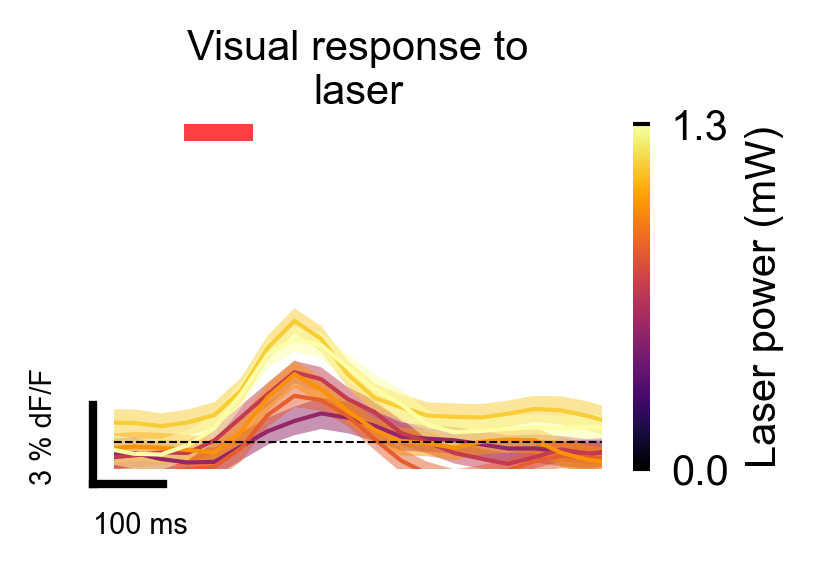

In [180]:
fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)
width_ratios = [1,1]
powerscorr = [round(i/2.777777778,2) for i in powers]

ax = plt.subplot(gs[0,0])
lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

for iP, power in enumerate(pxPowers):
    plt.fill_between(timestamps, \
            power-sems[iP],\
            power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)

#set colorbar
cm = mpl.cm.ScalarMappable(cmap='inferno') # creates a color mapping object
cm.set_clim(0, 1.3) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7} mW') # the power variable is in V (taken from data npys)
cbar = plt.colorbar(ax=ax,mappable=cm,label='Laser power (mW)') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1.3])
cbar.outline.set_visible(False)

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.03 # length of dff bar
x_start = 0 - 0.13 # where the bar should start
y_start = -0.016 # where the bar should start

plt.ylim([-.01,.12])
plt.xlim([-.1,0.6])
plt.axhline(0, color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
plt.title(f'Visual response to\nlaser')
plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.savefig('paperposterfigs/fig3b.pdf',dpi=300)

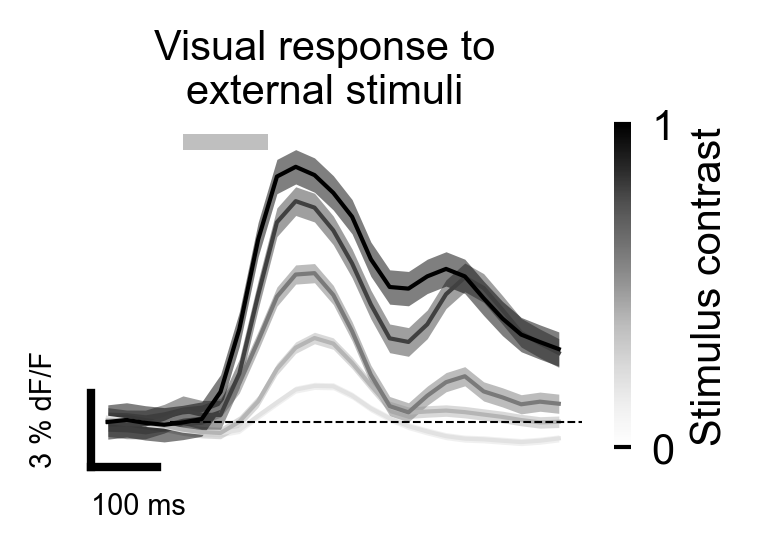

In [185]:
fig=plt.figure(figsize=(5,2),dpi=300)
gs = mpl.gridspec.GridSpec(1,2, figure=fig)

ax=plt.subplot(gs[0,0])
colors_grey = plt.cm.Greys(np.linspace(0.2,1,5))
for i,key in enumerate(linTest.keys()):
    contrast = np.mean(linTest.get(key),axis=0)
    plt.plot(linWindows,contrast,color=colors_grey[i])
    plt.fill_between(linWindows, \
            contrast-scipy.stats.sem(contrast,axis=0),\
            contrast+scipy.stats.sem(contrast,axis=0), color=colors_grey[i],label='_nolegend_',alpha=.5,linewidth=0)

plt.axvspan(0,.130,ymin=0.92,ymax=0.97,color='grey',alpha=0.5,lw=0)

cm = mpl.cm.ScalarMappable(cmap='Greys') # creates a color mapping objec
cm.set_clim(0, 1) # sets limits to our power mW limits - exp.v_to_mw is 2.7 here
# plt.plot(x, y, c=cm.to_rgba(power/2.7), label=f'{power/2.7:.1f} mW') # the power variable is in V (taken from data npys)
cbar=plt.colorbar(ax=ax,mappable=cm,label='Stimulus contrast') # tells the colorbar to use your colormap object
cbar.set_ticks([0,1])
cbar.outline.set_visible(False)
plt.title('Visual response to\nexternal stimuli')

#make scale bars
t_bar_s = 0.1 # length of time bar
dff_bar = 0.03 # length of dff bar
x_start = 0 - 0.14 # where the bar should start
y_start = -0.018 # where the bar should start
plt.ylim([-.01,.12])
plt.axhline(0, xmin=0.2,xmax=4,color='k', linestyle='--',lw=0.5)
plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])


fig.tight_layout()
fig.savefig('paperposterfigs/fig3c.pdf',dpi=300)

# c

In [281]:
def respQuantLoc(ax,data,galvoYList,powers,x=100,y=390,\
                 time=0.18,width=50,ylim=[-0.1,0.04],t=600,\
                    xl=True,yl=True,title=''):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    sems_final=[]
    labels=['Ant','Mid','Post']
    colors = plt.cm.Purples(np.linspace(.3,1,3))
    start=0
    end=.5
    time=0.18
    n_samples = round((start+end)*35)
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iD,yLoc in enumerate(galvoYList):
        pxPowers = []
        sems=[]
        galvoYTrs=np.argwhere(data.galvoY[:t]==yLoc).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[:t] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
        pxData.append(pxPowers)
        sems_final.append(sems)

    powerscorr = [round(i/2.777777778,2) for i in powers]
    for iD,data in enumerate(pxData):
        plt.plot(powerscorr,data,'-o',c=colors[iD],lw=2,label=labels[iD])
        plt.errorbar(powerscorr,data,yerr=sems_final[iD],c=colors[iD],label='_nolabel_')
        plt.scatter(powerscorr,data,label='_nolabel_')
    # plt.legend(loc='upper left')
    if xl:
        plt.xlabel("Laser power (mW)")
    if yl:
        plt.ylabel(f'Activity at peak in Visp (dF/F)')
    plt.ylim(ylim)
    plt.title(title)


In [45]:
def respQuantLocReturn(ax,data,galvoYList,powers,x=100,y=390,\
                 time=0.18,width=50,title='',ylim=[-0.1,0.04],t=600):
    '''
    plots 3 traces for 3 different locations to compare the activation of the visual cortex per location
    '''
    pxData=[]
    sems_final=[]
    trial_peaks_saved=[]
    labels=['Ant','Mid','Post']
    colors = plt.cm.Purples(np.linspace(.3,1,len(galvoYList)))
    start=0
    end=.5
    time=0.18
    n_samples = round((start+end)*35)
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for iD,yLoc in enumerate(galvoYList):
        pxPowers = []
        sems=[]
        locPeaks=[]
        galvoYTrs=np.argwhere(data.galvoY[:t]==yLoc).ravel()

        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[:t] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,galvoYTrs)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
            locPeaks.append(trial_peaks[:27])
        trial_peaks_saved.append(locPeaks)
        pxData.append(pxPowers)
        sems_final.append(sems)

    return pxData,sems_final,trial_peaks_saved

In [192]:
locAL35,semsLoc_AL35,trial_peaksAL35 = respQuantLocReturn(ax,dataVis910_AL35,[0,2,3.5],powers=np.unique(dataVis910_AL35.laserPowers),\
             x=450,y=415,time=0.18,width=15,title='',ylim=[-0.02,0.05],t=600)
locZYE, semsLoc_ZYE88, trial_peaksZYE88 = respQuantLocReturn(ax,dataVis823_ZYE,[0,2.5,4.5],powers=np.unique(dataVis823_ZYE.laserPowers),\
                x=415,y=380,time=0.17,width=15,title='',ylim=[-0.02,0.05],t=600)
locZYE2,semsLoc_ZYE87, trial_peaksZYE87 = respQuantLocReturn(ax,dataVis819_ZYE,[0,2,4.5],powers=np.unique(dataVis819_ZYE.laserPowers),\
                x=415,y=450,time=0.1,width=15,title='',ylim=[-0.02,0.05],t=600)

In [194]:
trial_peaksAL35 = np.array(trial_peaksAL35)
trial_peaksZYE88 = np.array(trial_peaksZYE88)
trial_peaksZYE87 = np.array(trial_peaksZYE87)


In [195]:
peaks_control=[trial_peaksAL35[:,:5,:],trial_peaksZYE88,trial_peaksZYE87]
peaks_control=np.array(peaks_control)
control_loc_error=np.zeros((3,5))
for i in range(3):
    for j in range(5):
        trs = peaks_control[:,i,j,:].flatten()
        control_loc_error[i,j]=scipy.stats.sem(trs)

In [387]:
np.save('paperposterfigs/locAL35.npy',locAL35)

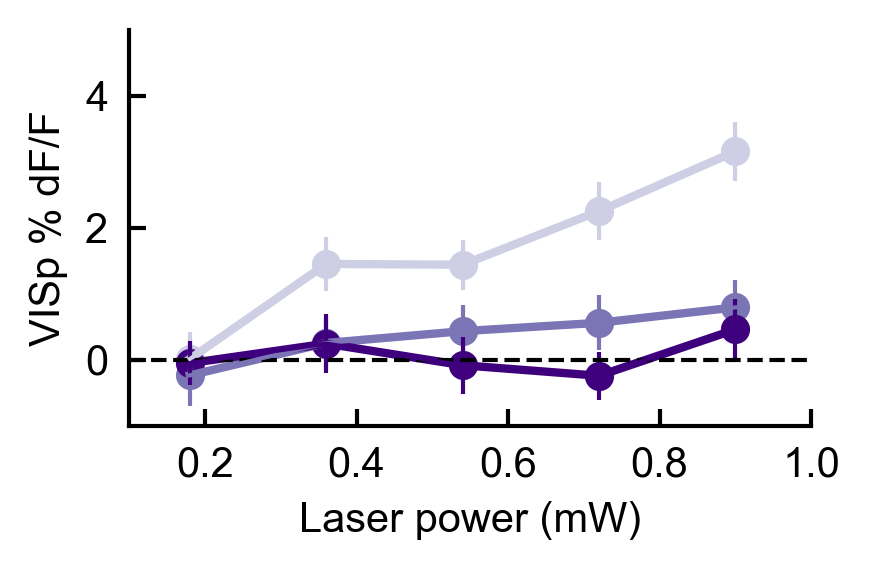

In [196]:
fig,ax=plt.subplots(figsize=(3,2),dpi=300)

dataList=[locAL35,locZYE,locZYE2]
labels=['Ant','Mid','Post']
colors = plt.cm.Purples(np.linspace(.3,1,3))
pows_mice=[[0.5,1,1.5,2,2.5,3],
           [0.5,1,1.5,2,2.5],
           [0.5,1,1.5,2,2.5]]
powers=[0.5,1,1.5,2,2.5]
powers = [round(i/2.777777778,2) for i in powers]
for loc in range(3):
    #plot avgs
    avg = np.mean([locAL35[loc][:5],locZYE[loc],locZYE2[loc]],axis=0)
    plt.plot(powers,avg,lw=2,color=colors[loc])
    plt.scatter(powers,avg,color=colors[loc])
    plt.errorbar(powers,avg,yerr=control_loc_error[loc],color=colors[loc])

    # #plot mouse lines
    # for mouse in range(3):
    #     data = dataList[mouse]
    #     pows_m = pows_mice[mouse]
    #     pows_m = [round(i/2.777777778,2) for i in pows_m]
    #     plt.plot(pows_m,data[loc],c=colors[loc],alpha=0.5,lw=1)

plt.ylim([-.01,.05])
plt.yticks([0,.02,.04],[0,2,4])
plt.xlim([0.1,1])
plt.xticks([0.2,0.4,0.6,0.8,1])
plt.axhline(0,c='black',ls='--')
plt.xlabel("Laser power (mW)")
plt.ylabel(f'VISp % dF/F')
fig.savefig('paperposterfigs/fig3d.pdf',dpi=300)

In [134]:
baselinesAL,activitiesAL=baselinesandactivities(dataVis910_AL35,galvoX=0,galvoY=0,x=400,y=415,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=15, tr1=0,tr2=600,trialtrs=27)
baselinesZYE1,activitiesZYE1=baselinesandactivities(dataVis830_AL23,galvoX=0,galvoY=0,x=415,y=415,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=15, tr1=0,tr2=1350,trialtrs=45)
baselinesZYE2,activitiesZYE2=baselinesandactivities(dataVis819_ZYE,galvoX=0,galvoY=0,x=415,y=450,baseline_ind=7,test_ind=7,start=-.2,end=0.14,width=15, tr1=0,tr2=600,trialtrs=35)

In [135]:
for i in range(5):
    concat_baselines = np.concatenate((baselinesAL[i],baselinesZYE1[i],baselinesZYE2[i]))
    concat_activities = np.concatenate((activitiesAL[i],activitiesZYE1[i],activitiesZYE2[i]))
    print(scipy.stats.ttest_rel(concat_baselines,concat_activities,axis=0))

TtestResult(statistic=-1.4940954114100438, pvalue=0.13812159363062643, df=106)
TtestResult(statistic=-1.4598467149684875, pvalue=0.14728961193284074, df=106)
TtestResult(statistic=-2.6847356230304746, pvalue=0.008425691167123467, df=106)
TtestResult(statistic=-2.706355582255383, pvalue=0.00792982709924672, df=106)
TtestResult(statistic=-4.526484686326744, pvalue=1.5744910975767562e-05, df=106)


# e

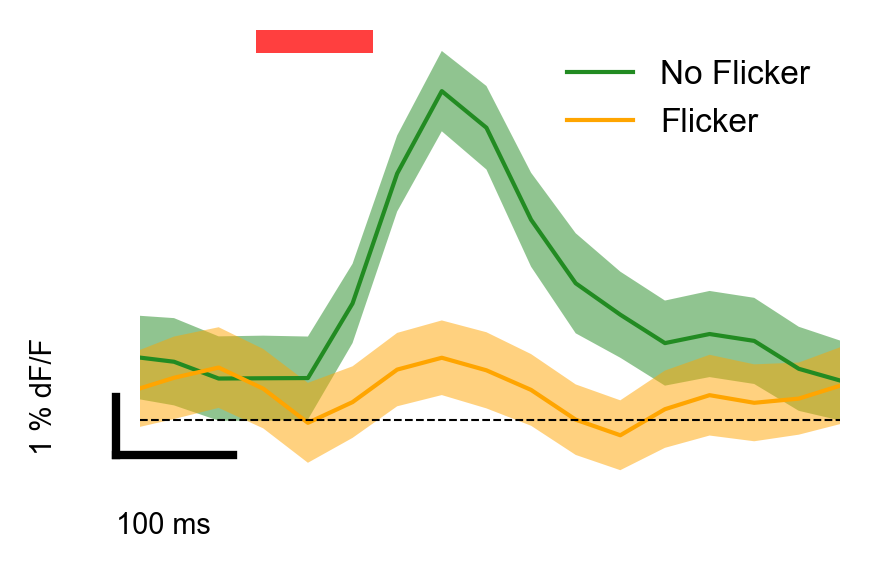

In [197]:
def visRespCompare(ax,data,ylim,xlim,exptrs=np.array([0,600,1200]),power=2.5,start=-.3,end=1,\
                   galvoX=0,galvoY=0,x=120,y=380,width=15,title="Response in VisP",\
                   labels=['No Flicker','Flicker'],legend=True):
    '''
    trace of response in VC compared with and without flicker 
    '''
    xTrace = []
    sems=[]
    colors=['forestgreen','orange']
    labels=['No Flicker','Flicker']
    n_samples=round(start*-1+end)*35
    timestamps = np.linspace(start, end, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    
    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        xTrace.append(np.mean(trial_activity,axis=0))

    for iP, trace in enumerate(xTrace):
        plt.plot(timestamps,trace, label=labels[iP], color=colors[iP])
        plt.fill_between(timestamps, \
                trace-sems[iP],\
                trace+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    plt.axvspan(0,.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
    plt.axhline(0, c='k',lw=0.5, ls='--')
    #make scale bars
    t_bar_s = 0.1 # length of time bar
    dff_bar = 0.01 # length of dff bar
    x_start = 0 - 0.12 # where the bar should start
    y_start = -0.006 # where the bar should start
    plt.legend()
    plt.xlim([-0.1,0.5])
    plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
    plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
    plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
    plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
    plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
fig,ax=plt.subplots(figsize=(3,2),dpi=300)
visRespCompare(ax,dataVis910_AL35,[-0.01,0.05],[-0.1,0.6],x=450,y=415)
fig.savefig('paperposterfigs/fig3f.pdf',dpi=300)

# f

In [231]:
def visrespcomparereturn(data,exptrs=[0,600,1200],galvoX=0,galvoY=0,x=120,y=380,width=30,time=0.18,ylim=[-0.01,0.04],trialtake=35):
    # powers=[0.5,1,1.5,2,2.5]
    powers=np.unique(data.laserPowers)
    lenpws = len(powers)

    quantCompare = np.zeros((2,lenpws),dtype=float)
    semsCompare = np.zeros((2,lenpws),dtype=float)
    trial_peaks_saved = np.zeros((2,lenpws,trialtake))
    n_samples=round((0.3+1)*35)
    timestamps = np.linspace(-0.3, 1, n_samples)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    noadapt_peaks_power=[]
    adapt_peaks_power=[]
    for i in range(2):
        pxPowers=[]
        sems=[]
        trial_peaks_power=[]
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
            trial_peaks_power.append(trial_peaks[:trialtake])
        trial_peaks_saved[i]=trial_peaks_power
        quantCompare[i]=pxPowers
        semsCompare[i]=sems

    return quantCompare,semsCompare,trial_peaks_saved

In [232]:
compare_AL35,semsAL35,trial_peaksAL= visrespcomparereturn(data=dataVis910_AL35,x=450,y=415,trialtake=29)
compare_AL23,sems_AL23,trial_peaksAL23= visrespcomparereturn(data=dataVis830_AL23,x=415,y=415,trialtake=45,exptrs=[0,1350,1800])
compare_ZYE2,sems_ZYE2,trial_peaksZYE2 = visrespcomparereturn(data=dataVis819_ZYE,x=415,y=450,trialtake=35)

In [111]:
compare_AL35.shape

(2, 6)

In [199]:
peaks_control=[trial_peaksAL[:,:5,:29],trial_peaksAL23[:,:5,:29],trial_peaksZYE2[:,:5,:29]]
peaks_control=np.array(peaks_control)
control_powers_error=np.zeros((2,5))
for i in range(2):
    for j in range(5):
        trs = peaks_control[:,i,j,:].flatten()
        control_powers_error[i,j]=scipy.stats.sem(trs)

to find error over differnces
- find for each trial in each condition the differences
- error 

In [211]:
peaks_control=[trial_peaksAL[:,:5,:29],trial_peaksAL23[:,:5,:29],trial_peaksZYE2[:,:5,:29]]
peaks_control=np.array(peaks_control)
control_diff_error=np.zeros(5)
for i in range(5):
    diff1 = trial_peaksAL[1,i,:29]-trial_peaksAL[0,i,:29]
    diff2=trial_peaksAL23[1,i,:29]-trial_peaksAL23[0,i,:29]
    diff3=trial_peaksZYE2[1,i,:29]-trial_peaksZYE2[0,i,:29]
    control_diff_error[i]=(scipy.stats.sem(np.concatenate((diff1,diff2,diff3)),axis=0))

In [212]:
control_diff_error

array([0.00454357, 0.00570742, 0.00553362, 0.004998  , 0.00483355])

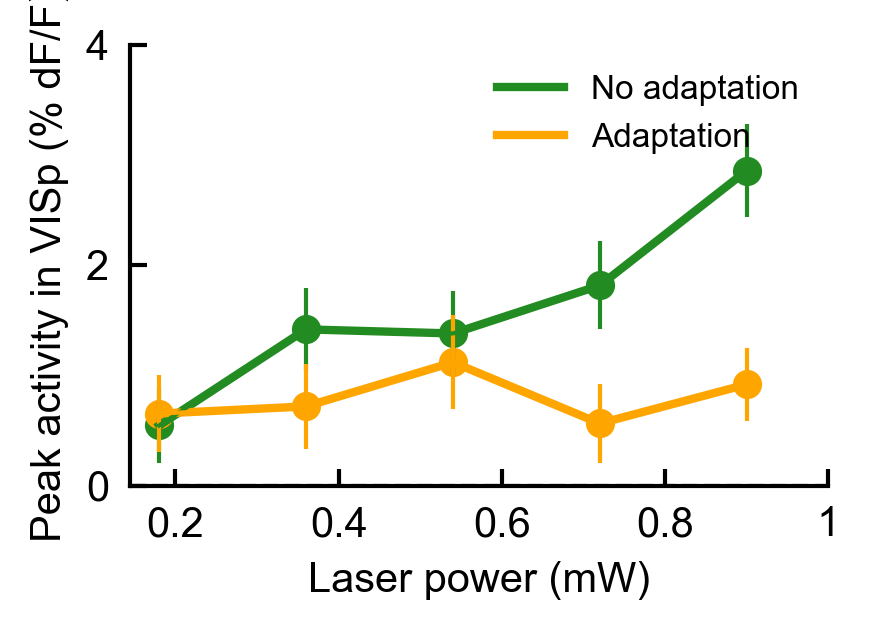

In [204]:
fig,ax=plt.subplots(figsize=(3,2.2),dpi=300)

dataList=[compare_AL35,compare_AL23,compare_ZYE2]

pows_mice=[[0.5,1,1.5,2,2.5],
           [0.5,1,1.5,2,2.5],
           [0.5,1,1.5,2,2.5]]
powers=[0.5,1,1.5,2,2.5]
powers = [round(i/2.777777778,2) for i in powers]
colors=['forestgreen','orange']
labels=['No adaptation','Adaptation']
avg_conds=[]
avg_errors=[]
for cond in range(2):
    #plot avgs
    avg = np.mean([compare_AL35[cond][:5],compare_AL23[cond][:5],compare_ZYE2[cond]][:5],axis=0)
    plt.plot(powers,avg,lw=2,color=colors[cond],label=labels[cond])
    plt.scatter(powers,avg,color=colors[cond])

    plt.errorbar(powers,avg,yerr=control_powers_error[cond],c=colors[cond],label='_nolabel_')
    
    avg_conds.append(avg)
    # for i in range(3):
    #     data = dataList[i]
    #     pows_m = pows_mice[i]
    #     pows_m = [round(i/2.777777778,2) for i in pows_m]
    #     plt.plot(pows_m,data[cond],c=colors[cond],alpha=0.5,lw=1)

plt.legend()
plt.axhline(0,linestyle='--',color='black')
plt.xlabel("Laser power (mW)")
plt.ylabel("Peak activity in VISp (% dF/F)")
plt.ylim([0,0.04])
plt.yticks([0,0.02,0.04],[0,2,4])
plt.xticks([0.2,0.4,0.6,0.8,1],[0.2,0.4,0.6,0.8,1])
fig.savefig('paperposterfigs/fig3g.pdf',dpi=300)

significance

In [124]:
def significance_adaptquant(data,galvoX,galvoY,start=0,end=0.2,width=30,x=120,y=380,trialtrs=35,exptrs=[0,600,1200]):
    powers=[0.5,1,1.5,2,2.5]
    meanimg = data.meanImage.reshape(560, 560, -1)
    avg = meanimg[(y - width):(y + width), (x - width):(x + width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
    # powers=np.unique(data.laserPowers)

    #checkers
    activity=[]

    for i in range(2):
        tr1 = exptrs[i]
        tr2 = exptrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        for i,pow in enumerate(powers):

            #get our trial activity for both baseline period and stim period 
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == pow).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                trial_activity.append(dff)
            trial_activity=np.array(trial_activity[:trialtrs])
            activity.append(trial_activity)

    activity = np.array(activity)
    activity=np.mean(activity,axis=2)
    # scipy.stats.ttest_rel(activity[:5,:],activity[5:,:],axis=1)
    return activity

In [304]:
activityAL23=significance_adaptquant(dataVis830_AL23,galvoX=0,galvoY=0,x=415,y=415,trialtrs=45,exptrs=[0,1350,1800],start=0.1,end=0.24,width=15)
scipy.stats.ttest_rel(activityAL23[:9,:],activityAL23[9:,:],axis=1)

TtestResult(statistic=array([ 1.60108455, -0.3036432 , -0.76063485, -2.36327165, -1.14361674,
        0.84474701,  0.38679524,  1.31861401,  0.37509262]), pvalue=array([0.11651451, 0.76283098, 0.45093228, 0.02259755, 0.25896659,
       0.4028221 , 0.70077223, 0.19412077, 0.70939364]), df=array([44, 44, 44, 44, 44, 44, 44, 44, 44]))

In [ ]:
activityAL35=significance_adaptquant(dataVis910_AL35,galvoX=0,galvoY=0,x=415,y=400,trialtrs=29)
activityAL23=significance_adaptquant(dataVis830_AL23,galvoX=0,galvoY=0,x=415,y=415,trialtrs=45)
activityZYE2=significance_adaptquant(dataVis819_ZYE,galvoX=0,galvoY=0,x=415,y=450)

In [126]:
activity_concat = np.concatenate((activityAL35,activityAL23,activityZYE2),axis=1)

In [127]:
scipy.stats.ttest_rel(activity_concat[:5,:],activity_concat[5:,:],axis=1)

TtestResult(statistic=array([-1.32820357,  0.73629483,  1.04828961,  2.61584182,  3.41928919]), pvalue=array([0.18691089, 0.46314758, 0.29684548, 0.01017433, 0.00088681]), df=array([108, 108, 108, 108, 108]))

[-0.01236784  0.00820607  0.00333532  0.00923459  0.00577309 -0.00346104
 -0.00710906 -0.01087985 -0.00067857]
[ 0.01346726 -0.02124434  0.00648564 -0.02090097 -0.04371895 -0.03517821]
[ 0.00213485 -0.00794244 -0.01767825 -0.02593185 -0.02029333]


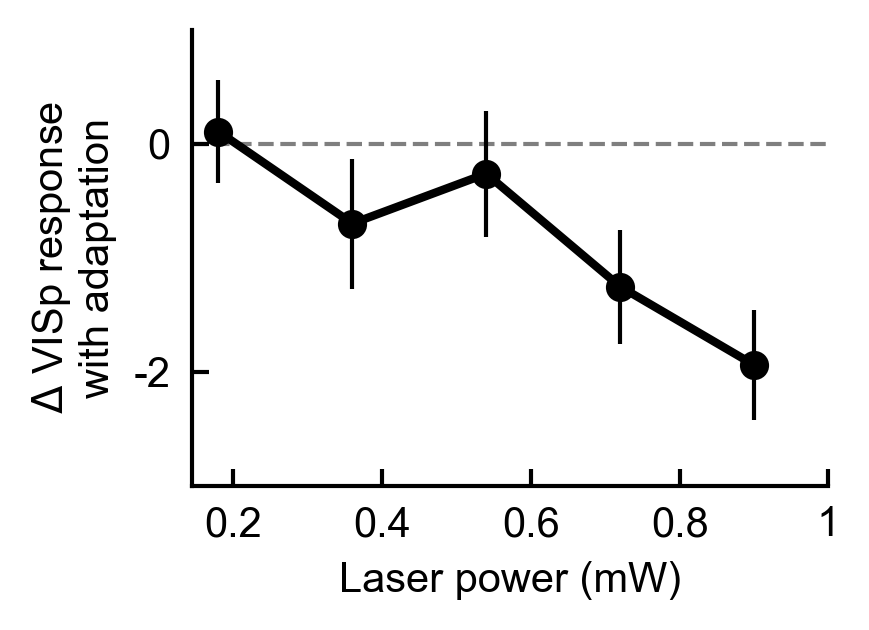

In [215]:
fig,ax=plt.subplots(figsize=(3,2.2),dpi=300)
powers=[0.5,1,1.5,2,2.5]
powscorr = [round(i/2.777777778,2) for i in powers]
dataList=[compare_AL23,compare_AL35,compare_ZYE2]
diff_adapt_mice = []
for mouse in dataList:
    diff_adapt = mouse[1][:5]-mouse[0][:5]
    print(mouse[1]-mouse[0])
    diff_adapt_mice.append(diff_adapt)

diff_adapt = np.mean(diff_adapt_mice,axis=0)
error = scipy.stats.sem(diff_adapt_mice,axis=0)
plt.plot(powscorr,diff_adapt,'-o',lw=2,color='k')
plt.errorbar(powscorr,diff_adapt,yerr=control_diff_error,c='k')
# for i in range(3):
#     plt.plot(powscorr,diff_adapt_mice[i],c='k',alpha=0.5)
plt.xlabel('Laser power (mW)')
plt.ylabel(f'$\Delta$ VISp response\nwith adaptation')
plt.axhline(0,linestyle='--',color='black',alpha=0.5)
plt.ylim([-0.03,0.01])
plt.yticks([-0.02,0],[-2,0])
plt.xticks([0.2,0.4,0.6,0.8,1],[0.2,0.4,0.6,0.8,1])
fig.savefig('paperposterfigs/fig3h.pdf',dpi=300)

In [21]:
print(diff_adapt*100)

[ 0.15735586 -0.24194715 -0.06161626 -0.8734635  -1.74548366]


# g

In [41]:
1/2.777777778

0.3599999999712

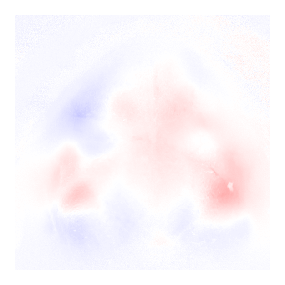

In [143]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
data=dataVis910_AL35
power=1
galvoX=0;galvoY=0;start=0;end=1
frame=6
vmax=0.05
vmin=-0.05
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[600:]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[600:]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[600:]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
plt.axis('off')
fig.savefig('paperposterfigs/3j_right.pdf',dpi=300)

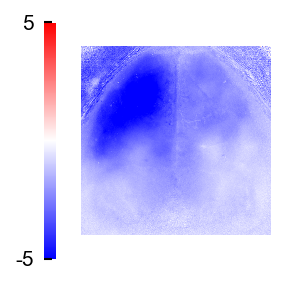

In [145]:
fig,ax=plt.subplots(1,1,figsize=(2,2))
data=dataOp425_AB32
power=1
galvoX=0;galvoY=0;start=0;end=1
frame=4
vmax=0.05
vmin=-0.05
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
plt.axis('off')
cbar = plt.colorbar(location='left')
cbar.outline.set_visible(False)
cbar.set_ticks([vmin,vmax])
cbar.set_ticklabels([-5,5])
fig.savefig('paperposterfigs/3i_left.pdf',dpi=300)

# h

In [117]:
def powerQuantReturn(data,powers,galvoX=0,galvoY=0,start=0,end=.5,x=150,y=380,n_samples=300,time=90,width=15):
    '''
    returns time at peak values into a variable which can later be used/compared
        data - dataset
        galvoX - X coordinate of laser
        galvoY - Y coordinate of laser
        x - X pixel to center ROI around
        y - Y pixel to center ROI around
        width - width of ROI on either side of X and Y
        time - at what time to take the peak
        n_samples - how many samples in the timeseries
    '''
    n_samples=round((end-start) * 35)
    timestamps = np.linspace(start,end, n_samples)
    pxPowers = []
    sems=[]
    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))
            
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTrs,galvoYTrs)

    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        trial_activity=[]
        trial_peaks=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
            trial_peaks.append(pixelInterpTrial(time))
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_peaks,axis=0))
        pxPowers.append(np.mean(trial_peaks,axis=0))

    return pxPowers,sems

In [118]:
def powerQuantReturnTrs(data,powers,galvoX=0,galvoY=0,start=0,end=.5,x=150,y=380,n_samples=300,time=90,width=15,expTrs=[0,600,1200]):
    n_samples=round((end-start) * 35)
    timestamps = np.linspace(start,end, n_samples)
    pxPowers = []
    sems=[]
    meanimg = data.meanImage.reshape(560,560,-1)
    avg=meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    powersTotal=[]
    semsTotal=[]
    for i in range(2):
        tr1=expTrs[i]
        tr2=expTrs[i+1]
        galvoXTrs=np.argwhere(data.galvoX[tr1:tr2]==galvoX).ravel()
        galvoYTrs=np.argwhere(data.galvoY[tr1:tr2]==galvoY).ravel()
        loc=np.intersect1d(galvoXTrs,galvoYTrs)
        pxPowers=[]
        sems=[]
        for iP, power in enumerate(powers):
            pwTrs = np.argwhere(data.laserPowers[tr1:tr2] == power).ravel()
            theseTrs=np.intersect1d(pwTrs,loc)
            onTimes = data.laserOn[theseTrs]
            trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
            trs = np.squeeze(np.array(trs))
            
            trial_activity=[]
            trial_peaks=[]
            for trial in trs:
                wf = data.tToWFManual(trial)
                mov = data.svdSpat[flat_indices] @ wf.T
                videoROI_avg = np.mean(mov,axis=0)
                dff = videoROI_avg/avg
                pixelInterpTrial = scipy.interpolate.interp1d(timestamps, dff, fill_value='extrapolate')
                trial_peaks.append(pixelInterpTrial(time))
                trial_activity.append(dff)
            sems.append(scipy.stats.sem(trial_peaks,axis=0))
            pxPowers.append(np.mean(trial_peaks,axis=0))
        powersTotal.append(pxPowers)
        semsTotal.append(sems)

    return powersTotal,semsTotal

## opto

In [35]:
pxPowers_opto=[]
sems_opto=[]
for data in [dataOp425_AB32, dataOp622_AL33, dataOp820_AL34]:
    pxPowers,sems = powerQuantReturn(data,np.unique(data.laserPowers),galvoX=0,galvoY=0,x=200,y=100,width=100,time=0.09)
    pxPowers_opto.append(pxPowers)
    sems_opto.append(sems)

In [35]:
np.save('pxPowers_opto.npy',pxPowers_opto)
np.save('sems_opto.npy',sems_opto)

NameError: name 'pxPowers_opto' is not defined

In [119]:
pxPowers_opto = np.load('pxPowers_opto.npy',allow_pickle=True)

In [120]:
sems_opto = np.load('sems_opto.npy',allow_pickle=True)

In [12]:
powers11 = np.unique(dataOp425_AB32.laserPowers)

opto significnace

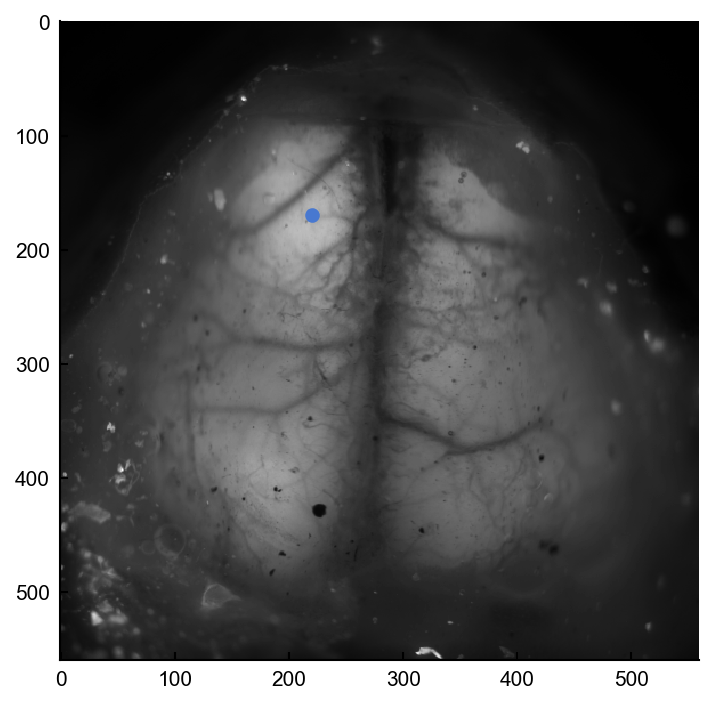

In [239]:
plt.imshow(dataOp820_AL34.meanImage.reshape(560,560,-1)[:,:,0],cmap='gray')
plt.scatter(x=220,y=170)

In [247]:
ttestpowquant(dataOp425_AB32,galvoX=0,galvoY=0,x=200,y=100,width=50,start=-0.3,end=0.12,baseline_ind=7,test_ind=7,trialtrs=40)

TtestResult(statistic=array([-0.315262  , -0.89777982,  3.83226565,  2.80659452,  6.68136887,
        4.90245546,  6.97532427, 10.10372054,  6.81726048,  8.29708374,
       13.5302545 ]), pvalue=array([7.54243506e-01, 3.74812123e-01, 4.50607663e-04, 7.77467617e-03,
       5.88513222e-08, 1.70304781e-05, 2.31696323e-08, 1.90895444e-12,
       3.82237134e-08, 3.81682475e-10, 2.58596554e-16]), df=array([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]))

In [248]:
ttestpowquant(dataOp622_AL33,galvoX=0,galvoY=0,x=230,y=120,width=50,start=-0.3,end=0.12,baseline_ind=7,test_ind=7,trialtrs=45)

TtestResult(statistic=array([-1.06350378, -0.50842536, -0.04363974,  1.55050327,  0.58887718,
        1.25292226,  0.59082038,  2.69393782,  5.55075232,  2.52804111,
        2.13901635]), pvalue=array([2.93355586e-01, 6.13694905e-01, 9.65389023e-01, 1.28184499e-01,
       5.58954955e-01, 2.16851860e-01, 5.57663658e-01, 9.95748931e-03,
       1.53641702e-06, 1.51344646e-02, 3.80220810e-02]), df=array([44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]))

In [249]:
ttestpowquant(dataOp820_AL34,galvoX=0,galvoY=0,x=220,y=170,width=50,start=-0.3,end=0.12,baseline_ind=7,test_ind=7,trialtrs=45)

TtestResult(statistic=array([-1.46422194e+00, -8.15362146e-03,  6.70291416e-01,  1.46632570e+00,
        9.67710679e-01,  5.79559831e+00,  5.38341913e+00,  1.06676727e+01,
        7.41681032e+00,  7.04943026e+00,  8.46257034e+00]), pvalue=array([1.51148054e-01, 9.93535990e-01, 5.06622005e-01, 1.50577001e-01,
       3.39152044e-01, 9.95816641e-07, 3.71238416e-06, 3.97603756e-13,
       5.77718510e-09, 1.83328443e-08, 2.31105617e-10]), df=array([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]))

In [252]:
baselinesAL,activitiesAL=baselinesandactivities(dataOp425_AB32,galvoX=0,galvoY=0,x=200,y=100,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=50,trialtrs=40)
baselinesZYE1,activitiesZYE1=baselinesandactivities(dataOp622_AL33,galvoX=0,galvoY=0,x=230,y=120,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=50,trialtrs=45)
baselinesZYE2,activitiesZYE2=baselinesandactivities(dataOp820_AL34,galvoX=0,galvoY=0,x=220,y=170,baseline_ind=7,test_ind=7,start=-.2,end=0.2,width=50, trialtrs=35)

In [253]:
for i in range(11):
    concat_baselines = np.concatenate((baselinesAL[i],baselinesZYE1[i],baselinesZYE2[i]))
    concat_activities = np.concatenate((activitiesAL[i],activitiesZYE1[i],activitiesZYE2[i]))
    print(scipy.stats.ttest_rel(concat_baselines,concat_activities,axis=0))

TtestResult(statistic=-1.351784154989618, pvalue=0.17900820663828196, df=119)
TtestResult(statistic=-1.127379227782308, pvalue=0.2618502323574827, df=119)
TtestResult(statistic=3.0875920367767375, pvalue=0.0025112139211798216, df=119)
TtestResult(statistic=7.485023342703889, pvalue=1.3608051599743091e-11, df=119)
TtestResult(statistic=6.309077028622999, pvalue=4.98067752285964e-09, df=119)
TtestResult(statistic=10.52476041891523, pvalue=1.037384797866177e-18, df=119)
TtestResult(statistic=10.623201162625637, pvalue=6.03742119669781e-19, df=119)
TtestResult(statistic=16.28879650402422, pvalue=4.442236926574731e-32, df=119)
TtestResult(statistic=19.83244314951677, pvalue=1.5725896450322153e-39, df=119)
TtestResult(statistic=16.295350898136668, pvalue=4.2972766750055357e-32, df=119)
TtestResult(statistic=14.926921235695692, pvalue=4.8854801981277793e-29, df=119)


## ctrl adapt

al23 x=420 y=410

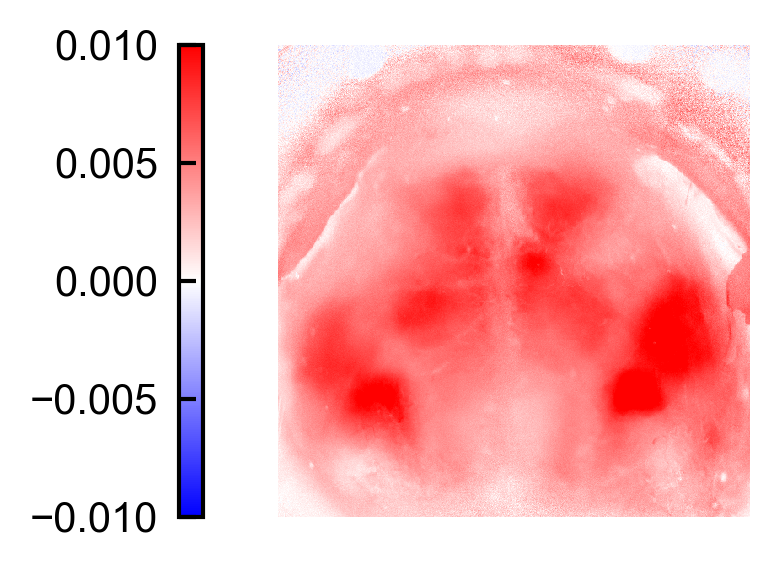

In [51]:
f = plt.figure(figsize=(3,2),dpi=300)
data=dataVis830_AL23
power=3
galvoX=0;galvoY=0;start=0;end=1
frame=7
vmax=0.01
vmin=-0.01
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[:1350]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[:1350]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[:1350]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.axis('off') 
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
cbar = plt.colorbar(location='left')
# plt.scatter(x=420,y=410,s=5,c='green')
plt.savefig('paperposterfigs/3a_right.pdf',dpi=300)

(-0.5, 559.5, 559.5, -0.5)

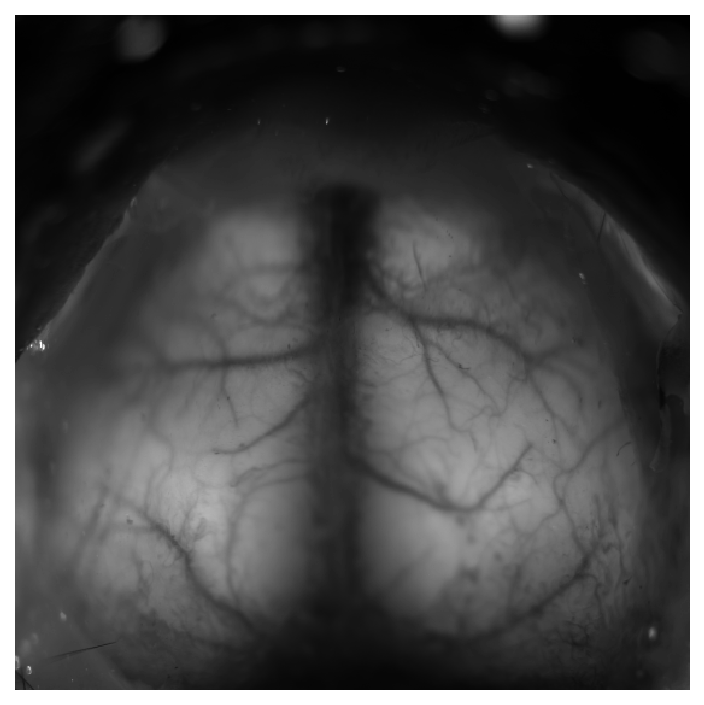

In [54]:
plt.imshow(dataVis830_AL23.meanImage,cmap='gray')
plt.savefig('paperposterfigs/3a_left.pdf',dpi=300)
plt.axis('off')

In [11]:
pxPowers_AL23, sems_AL23 = powerQuantReturnTrs(dataVis830_AL23,np.unique(dataVis830_AL23.laserPowers),\
                                               galvoX=0,galvoY=0,x=420,y=410,width=15,expTrs=[0,1350,1800],\
                                                time=0.18)

In [53]:
np.array(pxPowers_AL23).shape

(2, 9)

In [61]:
np.save('pxPowers_AL23.npy',pxPowers_AL23)
np.save('sems_AL23.npy',sems_AL23)

In [237]:
pxPowers_AL23 = np.load('pxPowers_AL23.npy',allow_pickle=True)
sems_AL23 = np.load('sems_AL23.npy',allow_pickle=True)

zye87 x=450 y=480

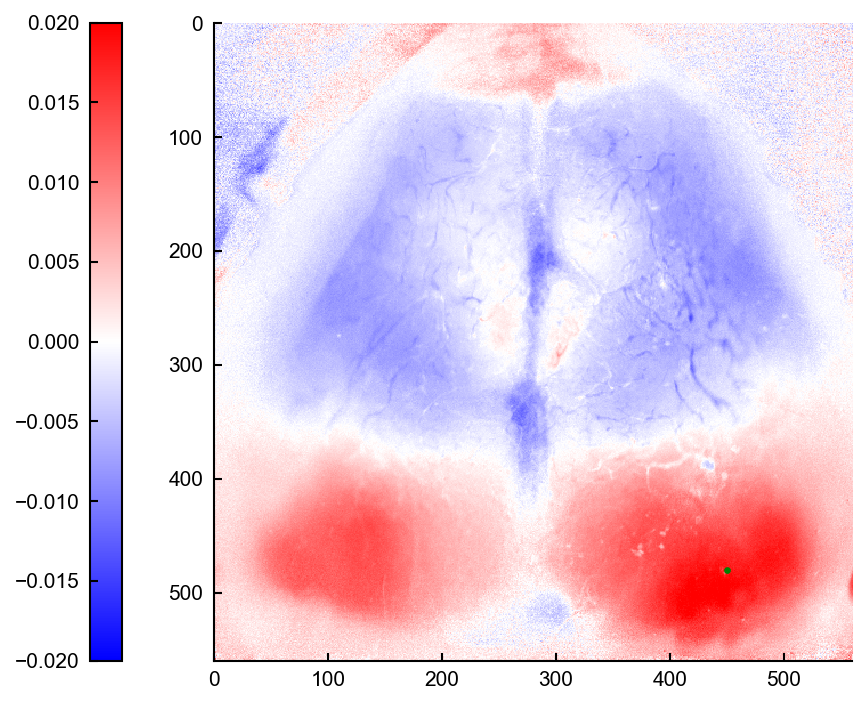

In [58]:
data=dataVis823_ZYE
power=2.5
galvoX=0;galvoY=0;start=0;end=1
frame=7
vmax=0.02
vmin=-0.02
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[:1350]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[:1350]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[:1350]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
cbar = plt.colorbar(location='left')
plt.scatter(x=450,y=480,s=5,c='green')

In [12]:
pxPowers_ZYE, sems_ZYE = powerQuantReturnTrs(dataVis823_ZYE,np.unique(dataVis823_ZYE.laserPowers),\
                                               galvoX=0,galvoY=0,x=450,y=450,width=15,expTrs=[0,600,1200],\
                                                time=0.18)

In [60]:
np.save('pxPowers_ZYE.npy',pxPowers_ZYE)
np.save('sems_ZYE.npy',sems_ZYE)

In [239]:
pxPowers_ZYE = np.load('pxPowers_ZYE.npy',allow_pickle=True)

In [240]:
sems_ZYE = np.load('sems_ZYE.npy',allow_pickle=True)

al35

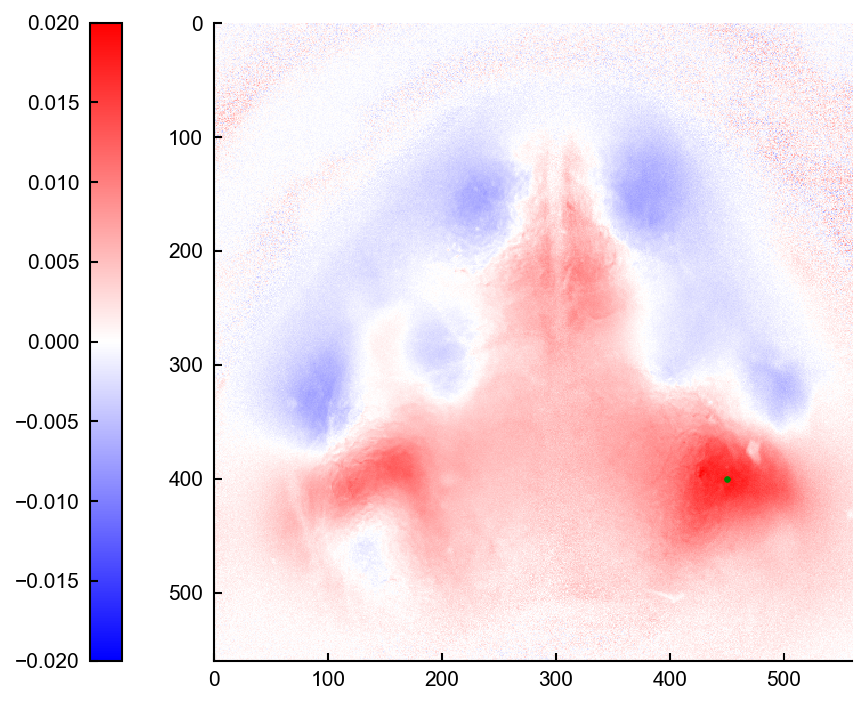

In [66]:
data=dataVis910_AL35
power=1.5
galvoX=0;galvoY=0;start=0;end=1
frame=7
vmax=0.02
vmin=-0.02
n_samples=round(35*(end-start))

pows = np.argwhere(data.laserPowers[:1350]==power).ravel()
galvoYTrs=np.argwhere(data.galvoY[:1350]==galvoY)
galvoXTrs=np.argwhere(data.galvoX[:1350]==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

onTimes = data.laserOn[theseTrs]
trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

wf = np.mean(data.tToWFManual(trs),axis=0)
mov = data.svdSpat @ wf.T #add back in spatial -- this now gives us F(t)
mov = mov.reshape(560,560,-1)
meanimg = data.meanImage.reshape(560,560,-1)
mov_mean_dff = mov/meanimg

pct99 = np.percentile(np.abs(mov_mean_dff), 99)
clim = np.r_[-1, 1]*pct99
plt.imshow(mov_mean_dff[:,:,frame], cmap='bwr', clim=clim,interpolation='none',vmax=vmax,vmin=vmin)
cbar = plt.colorbar(location='left')
plt.scatter(x=450,y=400,s=5,c='green')

In [13]:
pxPowers_AL35, sems_AL35 = powerQuantReturnTrs(dataVis910_AL35,np.unique(dataVis910_AL35.laserPowers),\
                                               galvoX=0,galvoY=0,x=450,y=400,width=15,expTrs=[0,600,1200],
                                               time=0.18)

In [59]:
np.save('pxPowers_AL35.npy',pxPowers_AL35)
np.save('sems_AL35.npy',sems_AL35)

In [238]:
pxPowers_AL35 = np.load('pxPowers_AL35.npy',allow_pickle=True)
sems_AL35 = np.load('sems_AL35.npy',allow_pickle=True)

## plot

In [243]:
ctrl_pows = [pxPowers_AL23,pxPowers_ZYE,pxPowers_AL35]
ctrl_sems=[sems_AL23,sems_ZYE,sems_AL35]

In [121]:
f=plt.figure(figsize=(3,2),dpi=300)

datacontrol = [[0.10, 0.25, 0.50, 0.75, 1.00, 1.50, 2.0, 2.5, 3.0],
               [0.5, 1, 1.5, 2, 2.5],
               [0.5, 1, 1.5, 2, 2.5, 3]]
dataOpPowers=[[0.1,0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2],
              [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 3.2],
              [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 3.2]
]
pows_mice=[[0.5,1,1.5,2,2.5,3],
           [0.5,1,1.5,2,2.5],
           [0.5,1,1.5,2,2.5]]
infernocolor = plt.cm.inferno(np.linspace(0,1,11))
colors=['forestgreen','orange']
linestyles=['-',':','--']
for i in range(2):
    data = datacontrol[j]
    pows=ctrl_pows[j][i]
    sems=ctrl_sems[j][i]
    c=colors[i]

    powers=np.unique(datacontrol[j])
    plt.plot(powers,pows,color=c,linestyle=linestyles[j])
    plt.errorbar(powers,pows,yerr=sems,color=c,linestyle=linestyles[j])
    plt.scatter(powers,pows,color=c,s=6)

oc=infernocolor[5]
for i in range(3):
    pws=np.unique(dataOpPowers[i])
    plt.plot(pws,pxPowers_opto[i],color=oc)
    plt.errorbar(pws,pxPowers_opto[i],yerr=sems_opto[i],color=oc)
    plt.scatter(pws,pxPowers_opto[i],color=oc,s=6)

plt.axhline(0.00,linestyle='--',color='black',alpha=0.5)
plt.xticks([0,1,2,3],[0,0.4,0.7,1])
plt.xlabel("Laser power (mW)")
plt.ylabel('Frontal cortex % dF/F')
f.savefig('paperposterfigs/fig3h_3x2.pdf',dpi=300)

IndexError: list index out of range

<Figure size 900x600 with 0 Axes>

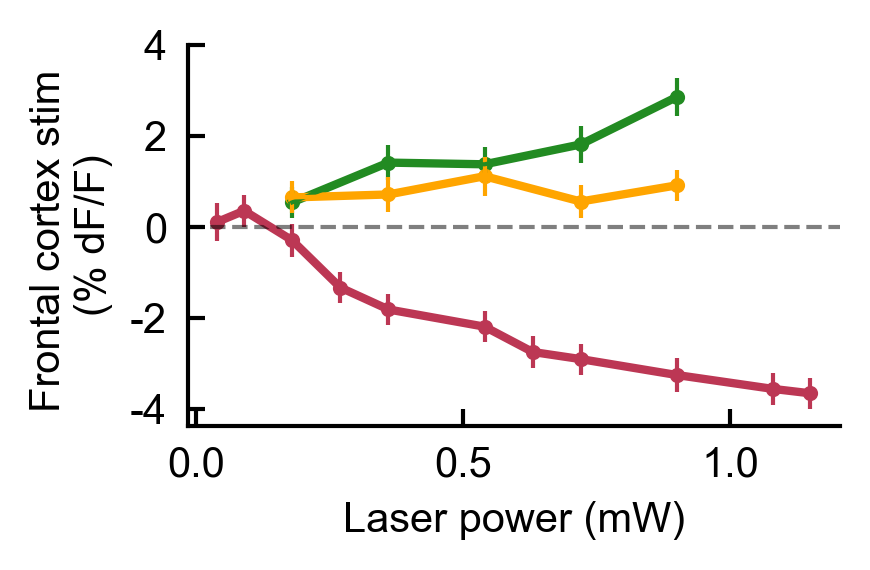

In [279]:
# with avg
f=plt.figure(figsize=(3,2),dpi=300)

pows_mice=[[0.5,1,1.5,2,2.5],
           [0.5,1,1.5,2,2.5],
           [0.5,1,1.5,2,2.5]]
powsshortcor=[round(i/2.777777778,2) for i in [0.5,1,1.5,2,2.5]]
dataOpPowers=[[0.1,0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2],
              [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 3.2],
              [0.1, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 3.2]
]

dataList=[compare_AL35,compare_AL23,compare_ZYE2]
sems=[semsAL35,sems_AL23,sems_ZYE2]
infernocolor = plt.cm.inferno(np.linspace(0,1,11))
colors=['forestgreen','orange']
linestyles=['-',':','--']
for i in range(2):
    plt.plot(powsshortcor,avg_conds[i],color=colors[i],lw=2)
    plt.scatter(powsshortcor,avg_conds[i],color=colors[i],s=7)
    plt.errorbar(powsshortcor,avg_conds[i],yerr=control_powers_error[i],c=colors[i],label='_nolabel_')
    # for mouse in range(3):
    #     data = dataList[mouse]
    #     plt.plot(pows_mice[mouse],data[i],color=colors[i],lw=0.5,alpha=0.5)
        # plt.errorbar(pows_mice[mouse],data[i],yerr=sems[mouse][i],color=colors[i],alpha=0.4)
        # plt.scatter(pows_mice[mouse],data[i],color=colors[i],s=1)
        
oc=infernocolor[5]
# for i in range(3):
#     pws=np.unique(dataOpPowers[i])
#     plt.plot(pws,pxPowers_opto[i],color=oc,lw=0.5,alpha=0.5)
    # plt.errorbar(pws,pxPowers_opto[i],yerr=sems_opto[i],color=oc,alpha=0.4)
    # plt.scatter(pws,pxPowers_opto[i],color=oc,s=6)
pws=[0.1,0.25,0.5,0.75,1,1.5,1.75,2,2.5,3,3.2]
pwscorr=[round(i/2.777777778,2) for i in pws]
mean_opto = np.mean(pxPowers_opto,axis=0)
plt.plot(pwscorr,mean_opto,color=oc,lw=2)
plt.errorbar(pwscorr,mean_opto,yerr=np.mean(sems_opto,axis=0),color=oc)
plt.scatter(pwscorr,mean_opto,color=oc,s=7)

plt.axhline(0.00,linestyle='--',color='black',alpha=0.5)
plt.xticks([0,0.5,1])
plt.yticks([-.04,-.02,0,0.02,0.04],[-4,-2,0,2,4])
plt.xlabel("Laser power (mW)")
plt.ylabel('Frontal cortex stim \n(% dF/F)')
f.savefig('paperposterfigs/fig3j.pdf',dpi=300)

In [275]:
3/2.777777778

1.0799999999136

In [266]:
3.2/2.777778

1.1519999078400074

## old

In [62]:
dataVis=dataVis910_AL35
dataOp=dataOp425_AB32
powers5 = np.unique(dataVis.laserPowers)

vis,visem = powerQuantReturn(data=dataVis,powers=powers5,galvoX=0,galvoY=0,x=120,y=380,time=.18,width=30)
opto,optosem = powerQuantReturn(data=dataOp,powers=np.unique(dataOp.laserPowers),galvoX=0,galvoY=0,x=100,y=200,time=.09,width=50)

interp_func = scipy.interpolate.interp1d(powers5, vis, kind='linear', fill_value='extrapolate')
controlinterp = interp_func(np.unique(dataOp.laserPowers))


In [63]:
interp_sem = scipy.interpolate.interp1d(powers5,visem,kind='linear',fill_value='extrapolate')
controlinterpsem = interp_sem(np.unique(dataOp.laserPowers))
sem=[optosem,controlinterpsem]

# supplemental

B, C, F, and H 

## B

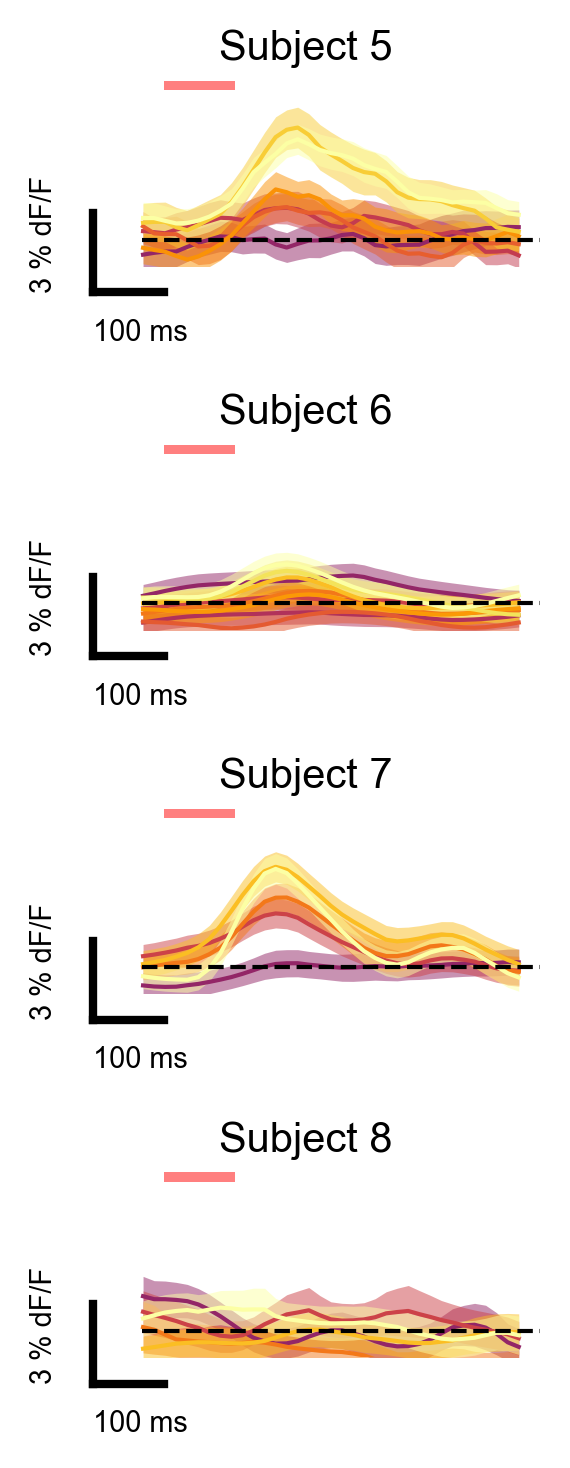

In [252]:
def plotvisrespsmall(ax,data,powers,x,y,width,t,start=-0.03,end=0.5,title=''):
    n_samples = round(start*-1+end)*35
    colors=plt.cm.inferno(np.linspace(.4,1,len(powers)))
    pxPowers = []
    sems=[]

    timestamps = np.linspace(start, end, n_samples)
    galvoXTr=np.argwhere(data.galvoX[:t]==0).ravel()
    galvoYTr=np.argwhere(data.galvoY[:t]==0).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    meanimg = data.meanImage.reshape(560,560,-1)
    avg = meanimg[(y-width):(y+width),(x-width):(x+width)]
    avg = np.mean(avg,axis=(0,1))

    y_range = np.arange(y - width, y + width)
    x_range = np.arange(x - width, x + width)
    # Create a meshgrid of the coordinates
    y_coords, x_coords = np.meshgrid(y_range, x_range, indexing='ij')
    # Flatten the coordinate arrays
    y_coords_flat = y_coords.flatten()
    x_coords_flat = x_coords.flatten()
    # Use np.ravel_multi_index to convert multi-dimensional indices to flat indices
    flat_indices = np.ravel_multi_index((y_coords_flat, x_coords_flat), (560, 560))

    for power in powers:
        pwTrs = np.argwhere(data.laserPowers[:t]== power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(start+on, end+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))

        trial_activity=[]
        for trial in trs:
            wf = data.tToWFManual(trial)
            mov = data.svdSpat[flat_indices] @ wf.T
            videoROI_avg = np.mean(mov,axis=0)
            dff = videoROI_avg/avg
            trial_activity.append(dff)
        sems.append(scipy.stats.sem(trial_activity,axis=0))
        pxPowers.append(np.mean(trial_activity,axis=0))
        powerscorr = [round(i/2.777777778,2) for i in powers]

    lines = [plt.plot(timestamps, y, label=f'{powerscorr[i]} mW',color=colors[i])[0] for i, y in enumerate(pxPowers)]

    for iP, power in enumerate(pxPowers):
        plt.fill_between(timestamps, \
                power-sems[iP],\
                power+sems[iP], color=colors[iP],label='_nolegend_',alpha=.5,linewidth=0)
    
    plt.axhline(0,xmin=0.15,xmax=4.5,linestyle='--',color='black')

    t_bar_s = 0.1 # length of time bar
    dff_bar = 0.03 # length of dff bar
    x_start = 0 - 0.1 # where the bar should start
    y_start = -0.02 # where the bar should start

    plt.ylim([-.01,.06])
    plt.plot([x_start, x_start+t_bar_s], [y_start, y_start], c='k', lw=2, clip_on=False) # these plot the bars
    plt.plot([x_start, x_start], [y_start, y_start+dff_bar], c='k', lw=2, clip_on=False)
    plt.text(x_start, y_start-0.01, f'{t_bar_s*1000:.0f} ms', ha='left', va='top', fontsize='x-small') # these are the text
    plt.text(x_start-0.05, y_start, f'{dff_bar*100:.0f} % dF/F', ha='right', va='bottom', rotation=90, fontsize='x-small')
    plt.title(f'{title}')
    plt.axvspan(0,0.1,ymin=0.95,ymax=1,color='red',lw=0,alpha=0.5)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    
f = plt.figure(figsize=(2,5),dpi=300)
gs = mpl.gridspec.GridSpec(4,1)

ax = f.add_subplot(gs[0])
plotvisrespsmall(ax,dataVis910_AL35,np.unique(dataVis910_AL35.laserPowers),x=400,y=415,width=15,t=600,title='Subject 5')

ax2 = f.add_subplot(gs[1])
plotvisrespsmall(ax2,dataVis830_AL23,np.unique(dataVis830_AL23.laserPowers),x=420,y=410,width=15,t=1350,title='Subject 6')

ax3 = f.add_subplot(gs[2])
plotvisrespsmall(ax3,dataVis819_ZYE,np.unique(dataVis819_ZYE.laserPowers),x=450,y=450,width=15,t=600,title='Subject 7')

ax4 = f.add_subplot(gs[3])
plotvisrespsmall(ax4,dataVis823_ZYE,np.unique(dataVis823_ZYE.laserPowers),x=100,y=200,width=15,t=600, title='Subject 8')
plt.colorbar

f.savefig('paperposterfigs/fig3supp_B.pdf',dpi=300)

## C

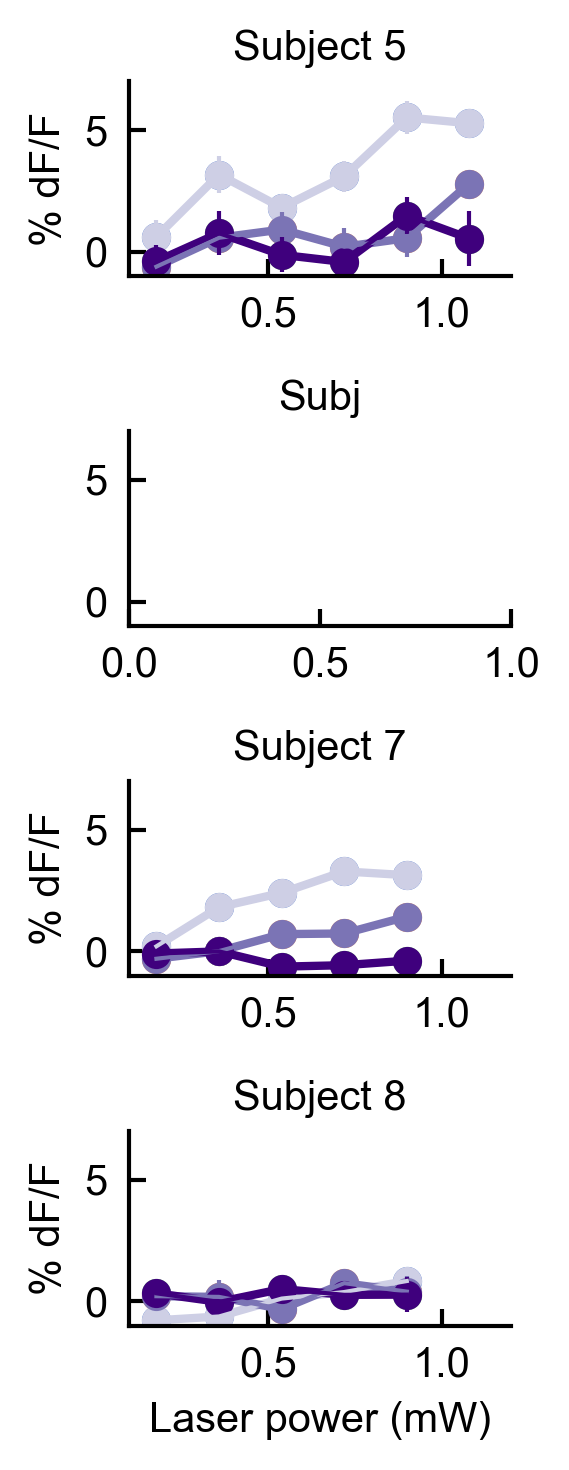

In [312]:
f = plt.figure(figsize=(2,5),dpi=300)
gs = mpl.gridspec.GridSpec(4,1)

ax = f.add_subplot(gs[0])
respQuantLoc(ax,data=dataVis910_AL35,powers=np.unique(dataVis910_AL35.laserPowers),galvoYList=np.unique(dataVis910_AL35.galvoY),\
             x=450,y=415,width=15,time=0.18,ylim=[-0.01,0.07],xl=False,yl=False,title='Subject 5')
plt.yticks([0, 0.05], [0, 5])
plt.xlim([0.1,1.2])
plt.ylabel('% dF/F')

ax = f.add_subplot(gs[1])
plt.title('Subj')
plt.ylim([-0.01,0.07])
plt.yticks([0, 0.05], [0, 5])

ax2 = f.add_subplot(gs[2])
p = np.unique(dataVis819_ZYE.laserPowers)
y = np.unique(dataVis819_ZYE.galvoY)
respQuantLoc(ax,data=dataVis819_ZYE,powers=p,galvoYList=y,x=415,y=450,width=15,time=0.18,\
             ylim=[-0.01,0.07],xl=False,yl=False,title='Subject 7')
plt.xlim([0.1,1.2])
plt.yticks([0, 0.05], [0, 5])
plt.ylabel('% dF/F')


ax3 = f.add_subplot(gs[3])
powers=np.unique(dataVis823_ZYE.laserPowers)
galvoY=np.unique(dataVis823_ZYE.galvoY)
respQuantLoc(ax,data=dataVis823_ZYE,powers=powers,galvoYList=galvoY,x=415,y=380,width=15,time=0.17,\
             ylim=[-0.01,0.07],yl=False,title='Subject 8')
plt.yticks([0, 0.05], [0, 5])
plt.xlim([0.1,1.2])
plt.ylabel('% dF/F')


f.tight_layout()
f.savefig('paperposterfigs/fig3supp_C.pdf',dpi=300)

In [186]:
ttestpowquant(dataVis910_AL35,galvoX=0,galvoY=0,x=400,y=415,width=15,start=-0.3,end=0.12,baseline_ind=7,test_ind=7,trialtrs=45,t=600)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

## F

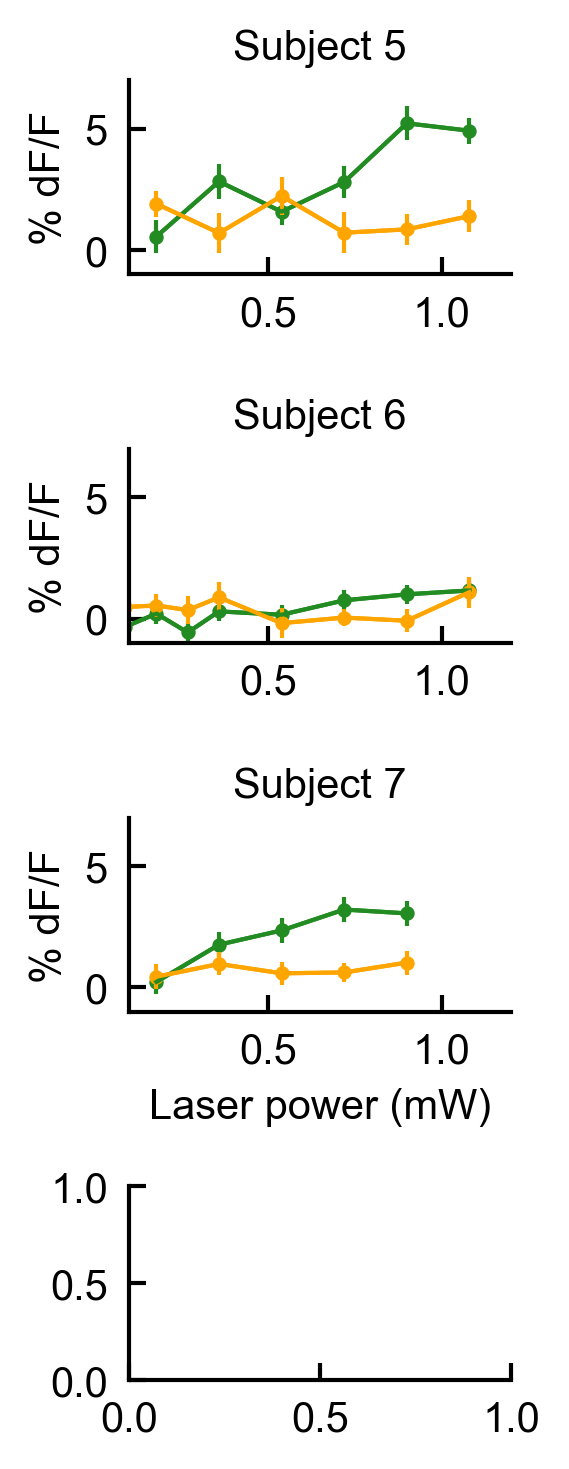

In [313]:
f = plt.figure(figsize=(2,5),dpi=300)
gs = mpl.gridspec.GridSpec(4,1)

dataList=[compare_AL35,compare_AL23,compare_ZYE2]
subjectList=['Subject 5','Subject 6','Subject 7']
semsList=[semsAL35,sems_AL23,sems_ZYE2]
pows_mice=[np.unique(dataVis910_AL35.laserPowers),
           np.unique(dataVis830_AL23.laserPowers),
           np.unique(dataVis819_ZYE.laserPowers)]
ylim=[-0.01,0.07]
colors=['forestgreen','orange']
for i in range(4):
    ax=f.add_subplot(gs[i])
    if i==3:
        continue
    for j in range(2):
        pows = [round(i/2.777777778,2) for i in pows_mice[i]]
        plt.plot(pows,dataList[i][j],color=colors[j])
        plt.errorbar(pows,dataList[i][j],yerr=semsList[i][j],color=colors[j])
        plt.scatter(pows,dataList[i][j],color=colors[j],s=6)
        plt.title(subjectList[i])
        plt.xlim([0.1,1.2])
        plt.yticks([0, 0.05], [0, 5])
        plt.ylabel('% dF/F')
        plt.ylim(ylim)
        if i==2:
            plt.xlabel('Laser power (mW)')

f.tight_layout()
f.savefig('paperposterfigs/fig3supp_F.pdf',dpi=300)

In [ ]:
ttestpowquant(data=dataVis,galvoX=0,galvoY=0,x=420,y=410,width=15,start=-0.3,end=0.12,baseline_ind=7,test_ind=7,trialtrs=45)

TtestResult(statistic=array([-3.40759657,  1.07625109, -0.32240789,  0.37825081, -0.3992814 ,
       -1.018452  , -1.20435289, -2.9175644 , -0.32545613]), pvalue=array([0.0014114 , 0.28768095, 0.7486707 , 0.70706312, 0.69161736,
       0.31403074, 0.23489187, 0.00553732, 0.74637854]), df=array([44, 44, 44, 44, 44, 44, 44, 44, 44]))

## F part 2

In [227]:
trial_peaksAL.shape

(2, 6, 29)

In [246]:
dataList=[compare_AL35,compare_AL23,compare_ZYE2]
peaksList=[trial_peaksAL,trial_peaksAL23,trial_peaksZYE2]
pows_mice=[np.unique(dataVis910_AL35.laserPowers),
           np.unique(dataVis830_AL23.laserPowers),
           np.unique(dataVis819_ZYE.laserPowers)]

diff_adapt_mice=[]
sems_adapt_mice=[]
for iM,mouse in enumerate(dataList):
    semmouse=[]
    diff_adapt = mouse[1]-mouse[0]
    diff_adapt_mice.append(diff_adapt)

    for i in range(len(pows_mice[iM])):
        mousetrials = peaksList[iM]
        semmouse.append(scipy.stats.sem(mousetrials[1][i]-mousetrials[0][i],axis=0))
    sems_adapt_mice.append(semmouse)


In [247]:
for mouse in sems_adapt_mice:
    print(len(mouse))

6
9
5


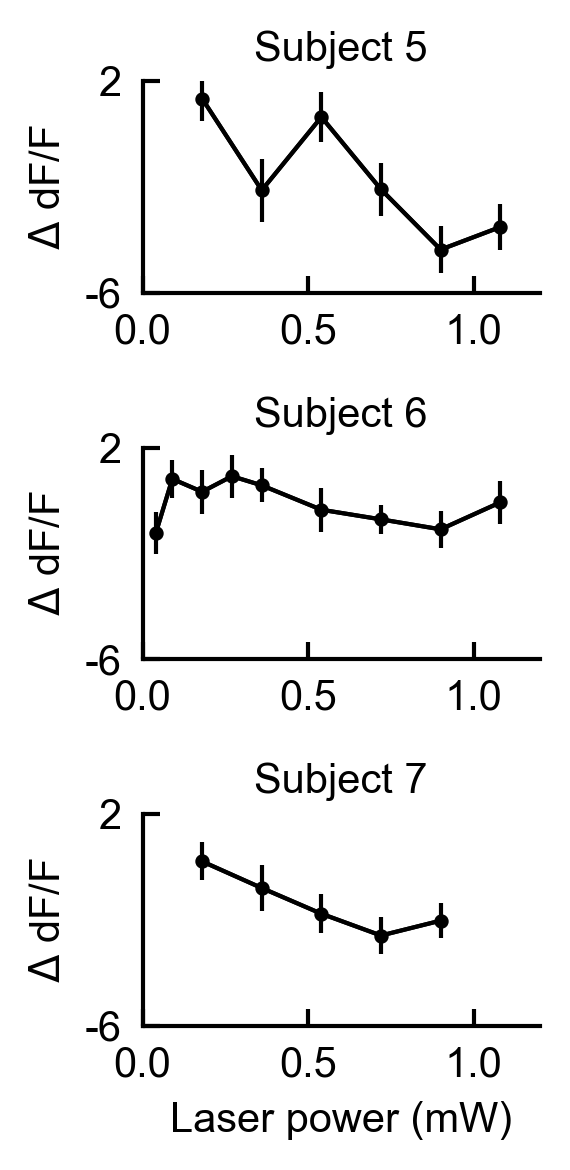

In [314]:
f = plt.figure(figsize=(2,4),dpi=300)
gs = mpl.gridspec.GridSpec(3,1)

ylim=[-0.06,0.02]
pows_mice=[np.unique(dataVis910_AL35.laserPowers),
           np.unique(dataVis830_AL23.laserPowers),
           np.unique(dataVis819_ZYE.laserPowers)]
subjectList=['Subject 5','Subject 6','Subject 7']
for iD, data in enumerate(diff_adapt_mice):
    powscorr = [round(i/2.777777778,2) for i in pows_mice[iD]]
    ax = f.add_subplot(gs[iD])
    ax.plot(powscorr,data,color='k')
    ax.errorbar(powscorr,data,yerr=sems_adapt_mice[iD],color='k')
    ax.scatter(powscorr,data,color='k',s=6)
    plt.title(subjectList[iD])
    ax.set_ylim(ylim)
    ax.set_xlim(0,1.2)
    plt.yticks([-0.06,0.02],[-6,2])
    plt.ylabel(r'$\Delta$ dF/F')
    if iD==2:
        ax.set_xlabel('Laser power (mW)')

f.tight_layout()
f.savefig('paperposterfigs/fig3supp_Fpt2.pdf',dpi=300)

## H

In [179]:
pxPowers_opto.shape

(3, 11)

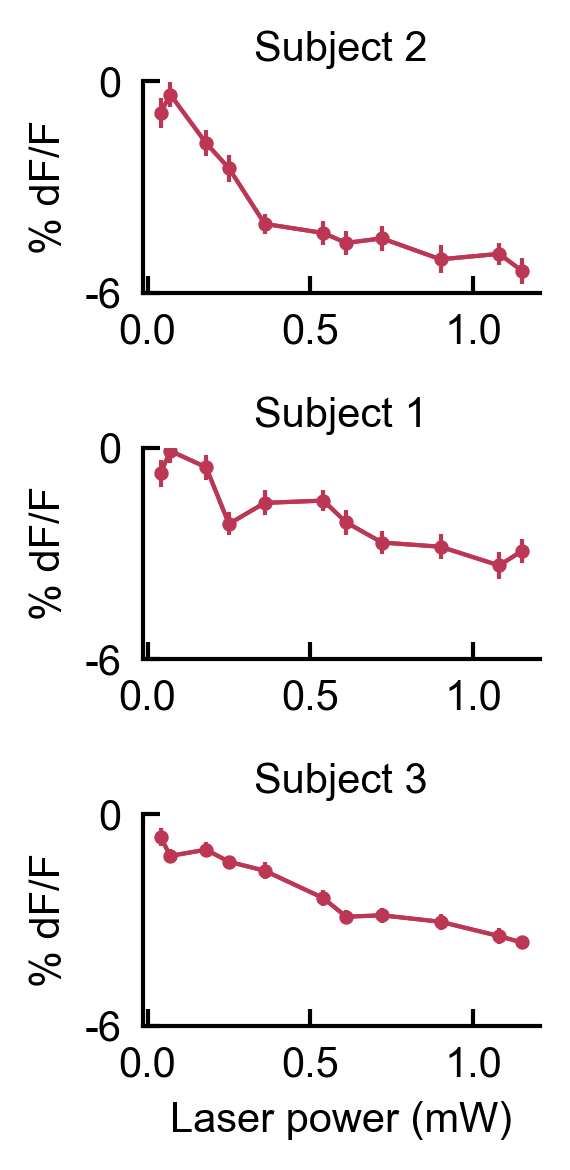

In [170]:
f = plt.figure(figsize=(2,4),dpi=300)
gs = mpl.gridspec.GridSpec(3,1)

subjectList=['Subject 2','Subject 1','Subject 3']
infernocolor = plt.cm.inferno(np.linspace(0,1,11))
ylim=[-0.06,0.01]
powscorr = [round(i/2.777777778,2) for i in np.unique(dataOp425_AB32.laserPowers)]
for iD, data in enumerate(pxPowers_opto):
    ax = f.add_subplot(gs[iD])
    ax.plot(powscorr,data,color=infernocolor[5])
    ax.scatter(powscorr,data,color=infernocolor[5],s=6)
    ax.errorbar(powscorr,data,yerr=sems_opto[iD],color=infernocolor[5])
    ax.set_title(subjectList[iD])
    ax.set_ylim(ylim)
    ax.set_ylabel('% dF/F')
    plt.yticks(ylim,[-6,0])
    if iD==2:
        ax.set_xlabel('Laser power (mW)')

f.tight_layout()
f.savefig('paperposterfigs/fig3supp_H.pdf',dpi=300)